In [131]:
import os
import sys
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

np.set_printoptions(precision=3)
pd.set_option('display.max_rows', None)

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [20, 16]

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio   
import plotly.express as px

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import re
re_num = re.compile(r'([0-9\.]+)(.*)')

#import env
os.getcwd()

'/home/kikim/Projects/ai_data_2022'

# 데이터 읽기 / 전처리

- 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 취합하여 비교하기
- 2022-07-20 현재 새로운 데이터 구조 
- json 파일 오류 및 관련 문의사항  
    * scan_speed 와 laser_power 값이 바뀐듯 함 
    * lamination_direction 값이 모두 0
    * layers 1995 이런값들이 맞는지 확인 
    * scan_speed 단위는 무슨 뜻인지? 
- 빈 칸 없애기, 단위 처리 등


## Mecanical Property 

In [132]:
# base_dir = os.path.join(f'/home', 'mygenie', 'data',  'AI_DB_CYAUTOTECH', 'new_versions')
base_dir = os.path.join(f'/data',  'AI_DB_CYAUTOTECH', '20220720')
!ls -al "$base_dir"

total 328
drwxrwsr-x+ 82 kikim dev 4096  7월 27 13:59 .
drwxrwsr-x+  3 kikim dev 4096  7월 26 19:09 ..
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:14 433_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:22 434_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:30 435_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:38 436_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:45 437_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:54 438_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:03 439_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:11 440_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:19 441_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:28 442_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:38 443_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:48 444_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:56 445_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 21:06 446_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  

In [133]:
data = dict()
data_list = list()
for i, trial in enumerate(sorted(os.listdir(base_dir))):
    if 'cycle' in trial:
        data_dir = os.path.join(base_dir, trial, 'On_Axis_Images')
        json_dir = os.path.join(base_dir, trial, "Mechanical property")
        meta_info = None
        # open one json file
        json_file = os.path.join(json_dir, 'property.json')
        with open(json_file, encoding='utf-8') as f:
            _info = json.load(f)
            if meta_info is None:
                meta_info = {k:set() for k in _info.keys()}
            for k, v in _info.items():
                if k != 'identifier':
                    meta_info[k].add(v)
        data[int(i)] = meta_info
        
        _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}
        __data = {}
        __data['materials'] = _data['materials.name']
        __data['equitments'] = _data['equipment.name']
        __data['sample_num'] = int(_data['sample_num'])
        __data['layer_num'] = int(_data['layers'])
        __data['laser_power'] = _data['conditions.scan_speed']
        __data['laser_speed'] = _data['conditions.laser_power']
        __data['density'] = _data['density']
        __data['yeild_stress'] = _data['yielding stress']
        __data['tensil_stress'] = _data['tensil stress']
        __data['elongation'] = _data['elongation']
        __data['lamination_direction'] = trial.split('_')[-2] 
        __data['trial_no'] = trial.split('_')[-1].split('cycle')[0]
        ___data = {}
        for k, v in __data.items():
            try: 
                val, unit = re_num.match(v).groups()
                knew = k if len(unit) == 0 else f'{k}({unit})'
                ___data.update({knew : float(val)})
            except: 
                ___data.update({k : v})
                
        data_list.append(___data)
        
df = pd.DataFrame(data_list)
df = df.rename(columns={'laser_power(bits/ms)':'laser_power(w)', 'laser_speed(w)':'laser_speed(bits/ms)'})
df['laser_density'] = np.divide(df['laser_power(w)'], df['laser_speed(bits/ms)']) #df['laser_power'] / df['laser_speed']

display(len(df))
df.iloc[1::16]

80

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
1,SUS,Vulcan 500,434,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,0.171429
17,SUS,Vulcan 500,450,274,264.0,1540.0,7.77,456.93,600.54,34.6,0.0,2.0,0.171429
33,SUS,Vulcan 500,466,274,264.0,1540.0,7.82,455.21,634.91,36.5,0.0,3.0,0.171429
49,SUS,Vulcan 500,482,1995,264.0,880.0,7.90,458.31,650.99,44.2,45.0,1.0,0.300000
65,SUS,Vulcan 500,498,1995,264.0,880.0,7.70,479.76,664.54,42.3,45.0,2.0,0.300000


In [134]:
df.columns

Index(['materials', 'equitments', 'sample_num', 'layer_num', 'laser_power(w)',
       'laser_speed(bits/ms)', 'density(g/cm^3)', 'yeild_stress(MPa)',
       'tensil_stress(MPa)', 'elongation(%)', 'lamination_direction',
       'trial_no', 'laser_density'],
      dtype='object')

### On-axis Images

In [135]:
dir_sus_0 = [d for d in sorted(os.listdir(base_dir)) if 'sus_0' in d]
dir_sus_45 = [d for d in sorted(os.listdir(base_dir)) if 'sus_45' in d]

In [136]:
avg_imgs = []

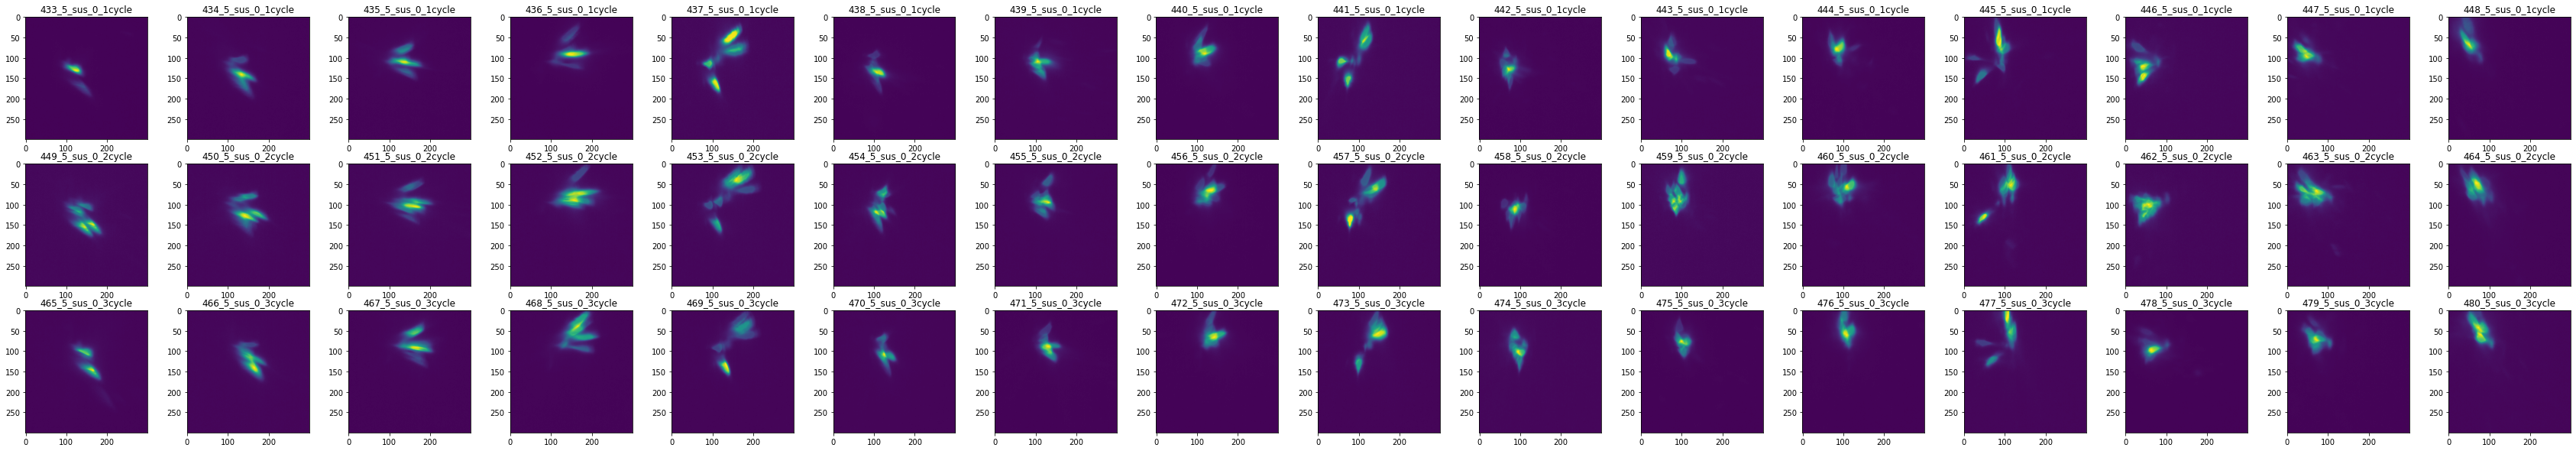

In [137]:
plt.figure(figsize=(60, 10))
for i, d in enumerate(dir_sus_0):
    plt.subplot(3, 16, i + 1)
    
    dir_img = os.path.join(base_dir, d, 'On_Axis_Images')
    img_list = []
    for f in sorted(os.listdir(dir_img))[::1000]:
        img = plt.imread(os.path.join(dir_img, f))
        img_list.append(np.expand_dims(img, axis=2))
    
    plt.imshow(np.concatenate(img_list, axis=2).mean(axis=2))
    plt.title(d)

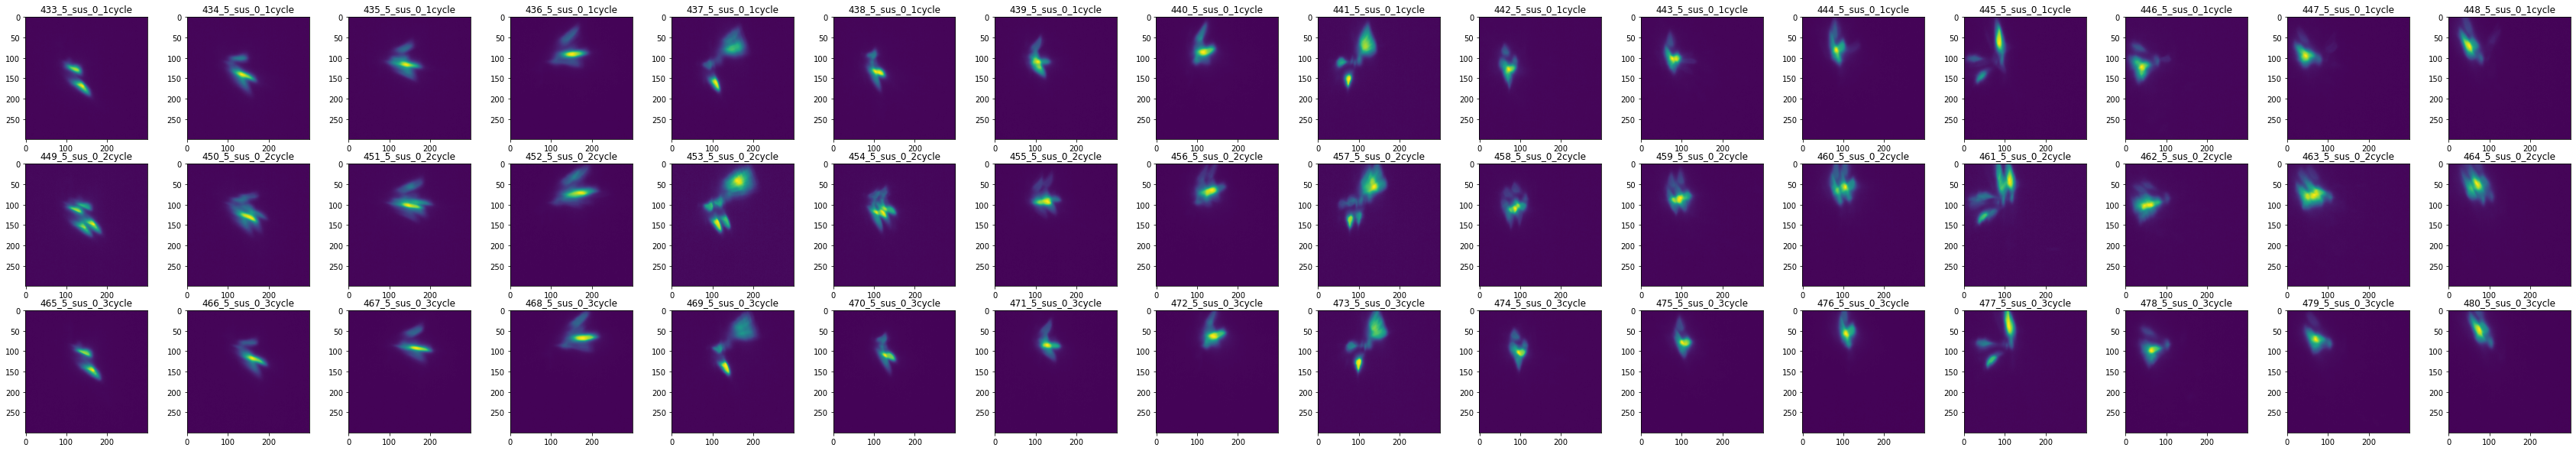

In [138]:
plt.figure(figsize=(60, 10))
for i, d in enumerate(dir_sus_0):
    plt.subplot(3, 16, i + 1)
    
    dir_img = os.path.join(base_dir, d, 'On_Axis_Images')
    img_list = []
    for f in sorted(os.listdir(dir_img))[::100]:
        img = plt.imread(os.path.join(dir_img, f))
        img_list.append(np.expand_dims(img, axis=2))
    
    avg_img = np.concatenate(img_list, axis=2).mean(axis=2)
    avg_imgs.append(avg_img)
    
    plt.imshow(avg_img)
    plt.title(d)

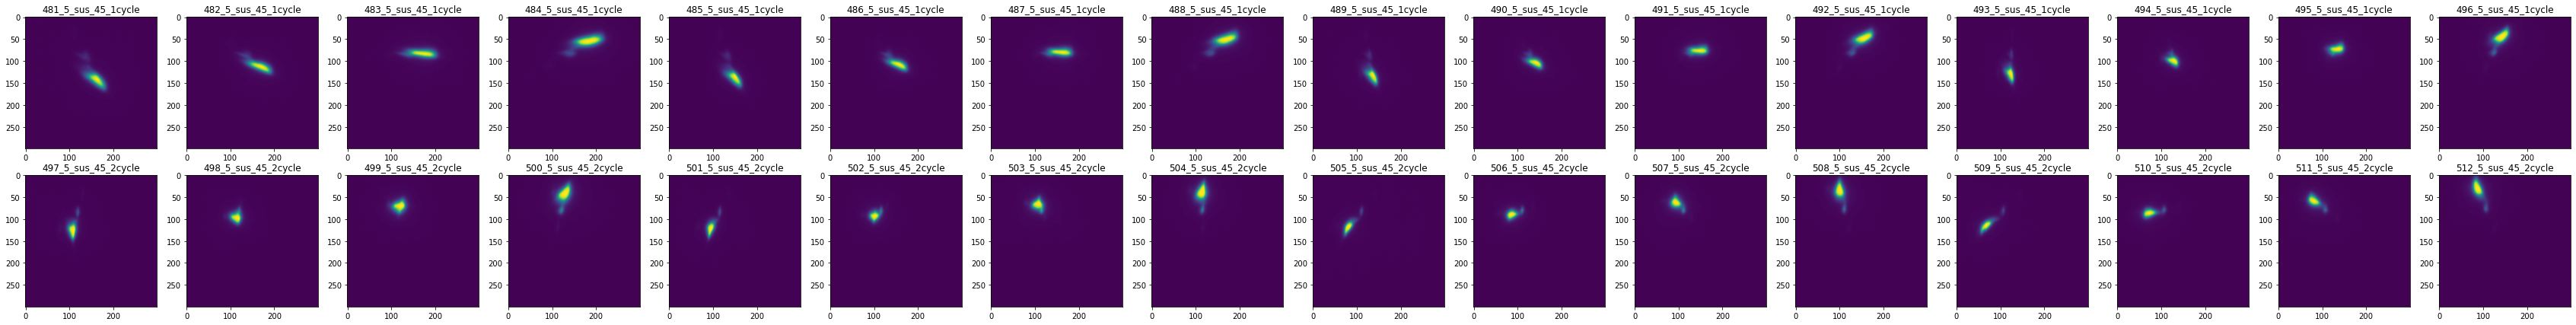

In [139]:
plt.figure(figsize=(60, 7))
for i, d in enumerate(dir_sus_45):
    plt.subplot(2, 16, i + 1)
    
    dir_img = os.path.join(base_dir, d, 'On_Axis_Images')
    img_list = []
    for f in sorted(os.listdir(dir_img))[::100]:
        img = plt.imread(os.path.join(dir_img, f))
        img_list.append(np.expand_dims(img, axis=2))
    
    avg_img = np.concatenate(img_list, axis=2).mean(axis=2)
    avg_imgs.append(avg_img)
    
    plt.imshow(avg_img)
    plt.title(d)

In [140]:
_avg_img_arr = np.concatenate([np.expand_dims(img, axis=2) for img in avg_imgs])
_avg_img_arr.mean(), _avg_img_arr.std()

(12.596858167325511, 12.335228881484202)

# Model

In [176]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Normalize, Lambda, Compose

np.random.seed(1)
torch.manual_seed(1)

## data preparation

In [177]:
_df = df.copy()
# _df.set_index('sample_num', inplace=True)

display(len(_df))
_df.head()

80

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
0,SUS,Vulcan 500,433,274,240.0,1540.0,7.64,449.14,633.20,25.0,0.0,1.0,0.155844
1,SUS,Vulcan 500,434,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,0.171429
2,SUS,Vulcan 500,435,274,312.0,1540.0,7.72,448.42,632.19,38.5,0.0,1.0,0.202597
3,SUS,Vulcan 500,436,274,360.0,1540.0,7.80,453.55,639.41,38.5,0.0,1.0,0.233766
4,SUS,Vulcan 500,437,274,240.0,1320.0,7.74,473.84,629.69,36.9,0.0,1.0,0.181818


In [178]:
_df.columns

Index(['materials', 'equitments', 'sample_num', 'layer_num', 'laser_power(w)',
       'laser_speed(bits/ms)', 'density(g/cm^3)', 'yeild_stress(MPa)',
       'tensil_stress(MPa)', 'elongation(%)', 'lamination_direction',
       'trial_no', 'laser_density'],
      dtype='object')

In [179]:
prop_cols = ['yeild_stress(MPa)', 'tensil_stress(MPa)', 'elongation(%)', 'density(g/cm^3)', ]
cond_cols = [
#     'materials', 'equitments', 
    'lamination_direction', 'laser_power(w)', 'laser_speed(bits/ms)', 'laser_density'
]

img_sub_dir='On_Axis_Images'
sub_dir_pattern='{sample_num}_5_{materials.lower()}_{int(lamination_direction)}_{trial_no}', 

In [180]:
is_train = np.random.rand(len(_df)) < 0.8

df_train = _df.loc[is_train, :]
df_test = _df.loc[~is_train, :]

In [181]:
display(len(df_train))
df_train.head()

66

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
0,SUS,Vulcan 500,433,274,240.0,1540.0,7.64,449.14,633.20,25.0,0.0,1.0,0.155844
1,SUS,Vulcan 500,434,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,0.171429
2,SUS,Vulcan 500,435,274,312.0,1540.0,7.72,448.42,632.19,38.5,0.0,1.0,0.202597
3,SUS,Vulcan 500,436,274,360.0,1540.0,7.80,453.55,639.41,38.5,0.0,1.0,0.233766
4,SUS,Vulcan 500,437,274,240.0,1320.0,7.74,473.84,629.69,36.9,0.0,1.0,0.181818


In [182]:
display(len(df_test))
df_test.head()

14

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
13,SUS,Vulcan 500,446,274,264.0,880.0,7.81,469.89,646.78,40.4,0.0,1.0,0.300000
20,SUS,Vulcan 500,453,274,240.0,1320.0,7.88,465.90,630.88,40.4,0.0,2.0,0.181818
21,SUS,Vulcan 500,454,274,264.0,1320.0,7.87,452.47,645.46,40.4,0.0,2.0,0.200000
24,SUS,Vulcan 500,457,274,240.0,1100.0,7.83,485.76,654.91,40.4,0.0,2.0,0.218182
25,SUS,Vulcan 500,458,274,264.0,1100.0,7.63,487.27,656.09,38.5,0.0,2.0,0.240000


In [183]:
def sample_to_sub_dir(sample : pd.Series, ):
    sample_num = sample['sample_num']
    material = sample['materials'].lower()
    lam_dir = int(sample['lamination_direction'])
    trial_no = int(sample['trial_no'])
    
    return f'{sample_num}_5_{material}_{lam_dir}_{trial_no}cycle'


def read_avg_image(img_dir, num_img=100):
    img_list = []
    
    img_files = np.random.choice(sorted(os.listdir(img_dir)), num_img)
    
    for f in img_files:
        img = plt.imread(os.path.join(img_dir, f))
        img_list.append(np.expand_dims(img, axis=2))
    
    return np.concatenate(img_list, axis=2).mean(axis=2)


In [184]:
avg_img_list = []


In [186]:
# img_list = []

# for i, row in df_train.iterrows():
#     sample = row#.to_frame().transpose()
#     sample_to_sub_dir(sample)
#     sub_dir = sample_to_sub_dir(sample)
#     img_dir = os.path.join(base_dir, sub_dir, img_sub_dir)
#     img = read_avg_image(img_dir, 10)
#     img_list.append(np.expand_dims(img, axis=2))
    
# avg_img_arr = np.concatenate(img_list, axis=2)

# img_mean, img_std = avg_img_arr.mean(), avg_img_arr.std()
# img_mean, img_std

In [187]:
class SpecimenDataset(Dataset):
    
    def __init__(self, df, base_dir, 
                 transform_x=None, 
                 transform_x_img=None,
                 transform_y=None):
        self.df = df
        self.base_dir = base_dir
        self.img_sub_dir = img_sub_dir
        
        self.transform_x = transform_x
        self.transform_x_img = transform_x_img
        self.transform_y = transform_y
        
    def __getitem__(self, idx):
        
        sample = self.df.iloc[idx, :]
        sample_num = sample['sample_num']
        
        x = sample[cond_cols].values
        y = sample[prop_cols].values
        
        sub_dir = sample_to_sub_dir(sample)
        img_dir = os.path.join(self.base_dir, sub_dir, img_sub_dir)
        x_img = read_avg_image(img_dir)
        
        
        if self.transform_x is not None:
            x = self.transform_x(x)
            
        if self.transform_x is not None:
            x_img = self.transform_x_img(x)
            
        if self.transform_y is not None:
            y = self.transform_y(y)
        
        return (x.astype(np.float32), x_img.astype(np.float32), y.astype(np.float32), sample_num, idx)
    
    def __len__(self):
        return len(self.df)
        
        
class Normalizer:
    """
    최소/최대 [-1, 1] 범위로 정규화
    """ 
    def __init__(self, mins=np.zeros(0), maxs=np.zeros(0), diffs=np.ones(0)):
        self.mins = mins
        self.maxs = maxs
        self.diffs = diffs
        
    def fit(self, array):
        self.mins = array.min(axis=0)
        self.maxs = array.max(axis=0)
        self.diffs = (self.maxs - self.mins) * 0.5
        
        return self
        
    def __call__(self, sample):
        return (sample - self.mins) / self.diffs - 1
    
    def inverse_tranform(self, normalized):
        return (normalized + 1) * self.diffs[None, :] + self.mins[None, :]


class Standardizer:
    """
    정규화
    """ 
    def __init__(self, means=np.zeros(0), stds=np.ones(0)):
        self.means = means
        self.stds = stds
        
    def fit(self, array):
        self.means = array.mean(axis=0)
        self.stds = array.std(axis=0)
        
        self.stds[self.stds == 0] = 1
        
        return self
        
    def __call__(self, sample):
        return (sample - self.means) / self.stds
    
    def inverse_tranform(self, normalized):
        return normalized * self.stds[None, :] + self.means[None, :]


In [188]:
normalizer_x = Standardizer().fit(df_train[cond_cols].values)
normalizer_y = Standardizer().fit(df_train[prop_cols].values)

transform_x = Compose([normalizer_x])
transform_y = Compose([normalizer_y])

In [189]:
## 이미지의 경우 대다수의 픽셀이 0, 불꽃 부위만 256에 가까운 값을 가져서, [-1, 1] 범위로 변환만 함

transform_x_img = Compose([Lambda(lambda x: x / 256. * 2 - 1), ToTensor()])

In [190]:
train_dataset = SpecimenDataset(df_train, base_dir, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)
test_dataset = SpecimenDataset(df_test, base_dir, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)

print(len(train_dataset))
print(len(test_dataset))

66
14
